In [1]:
# custom module
import topodisc as td

import numpy as np
from numpy import radians as rad
from numpy import degrees as deg
from numpy import sin, cos, tan, arcsin, arccos, arctan, arctan2, mean

import pandas as pd
from dataclasses import dataclass
import itertools

import warnings
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import mean_squared_error

warnings.simplefilter("error", OptimizeWarning)

from typing import Callable, Tuple
from collections.abc import Iterable

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

Confirm tilt calculations work as expected.

/Users/henry/GEOL192/GEOL192-Manuscript/topodisc.py:114: RuntimeWarning: divide by zero encountered in double_scalars
  argument = sin(beta2) * sin(sl2) / sin(beta1)


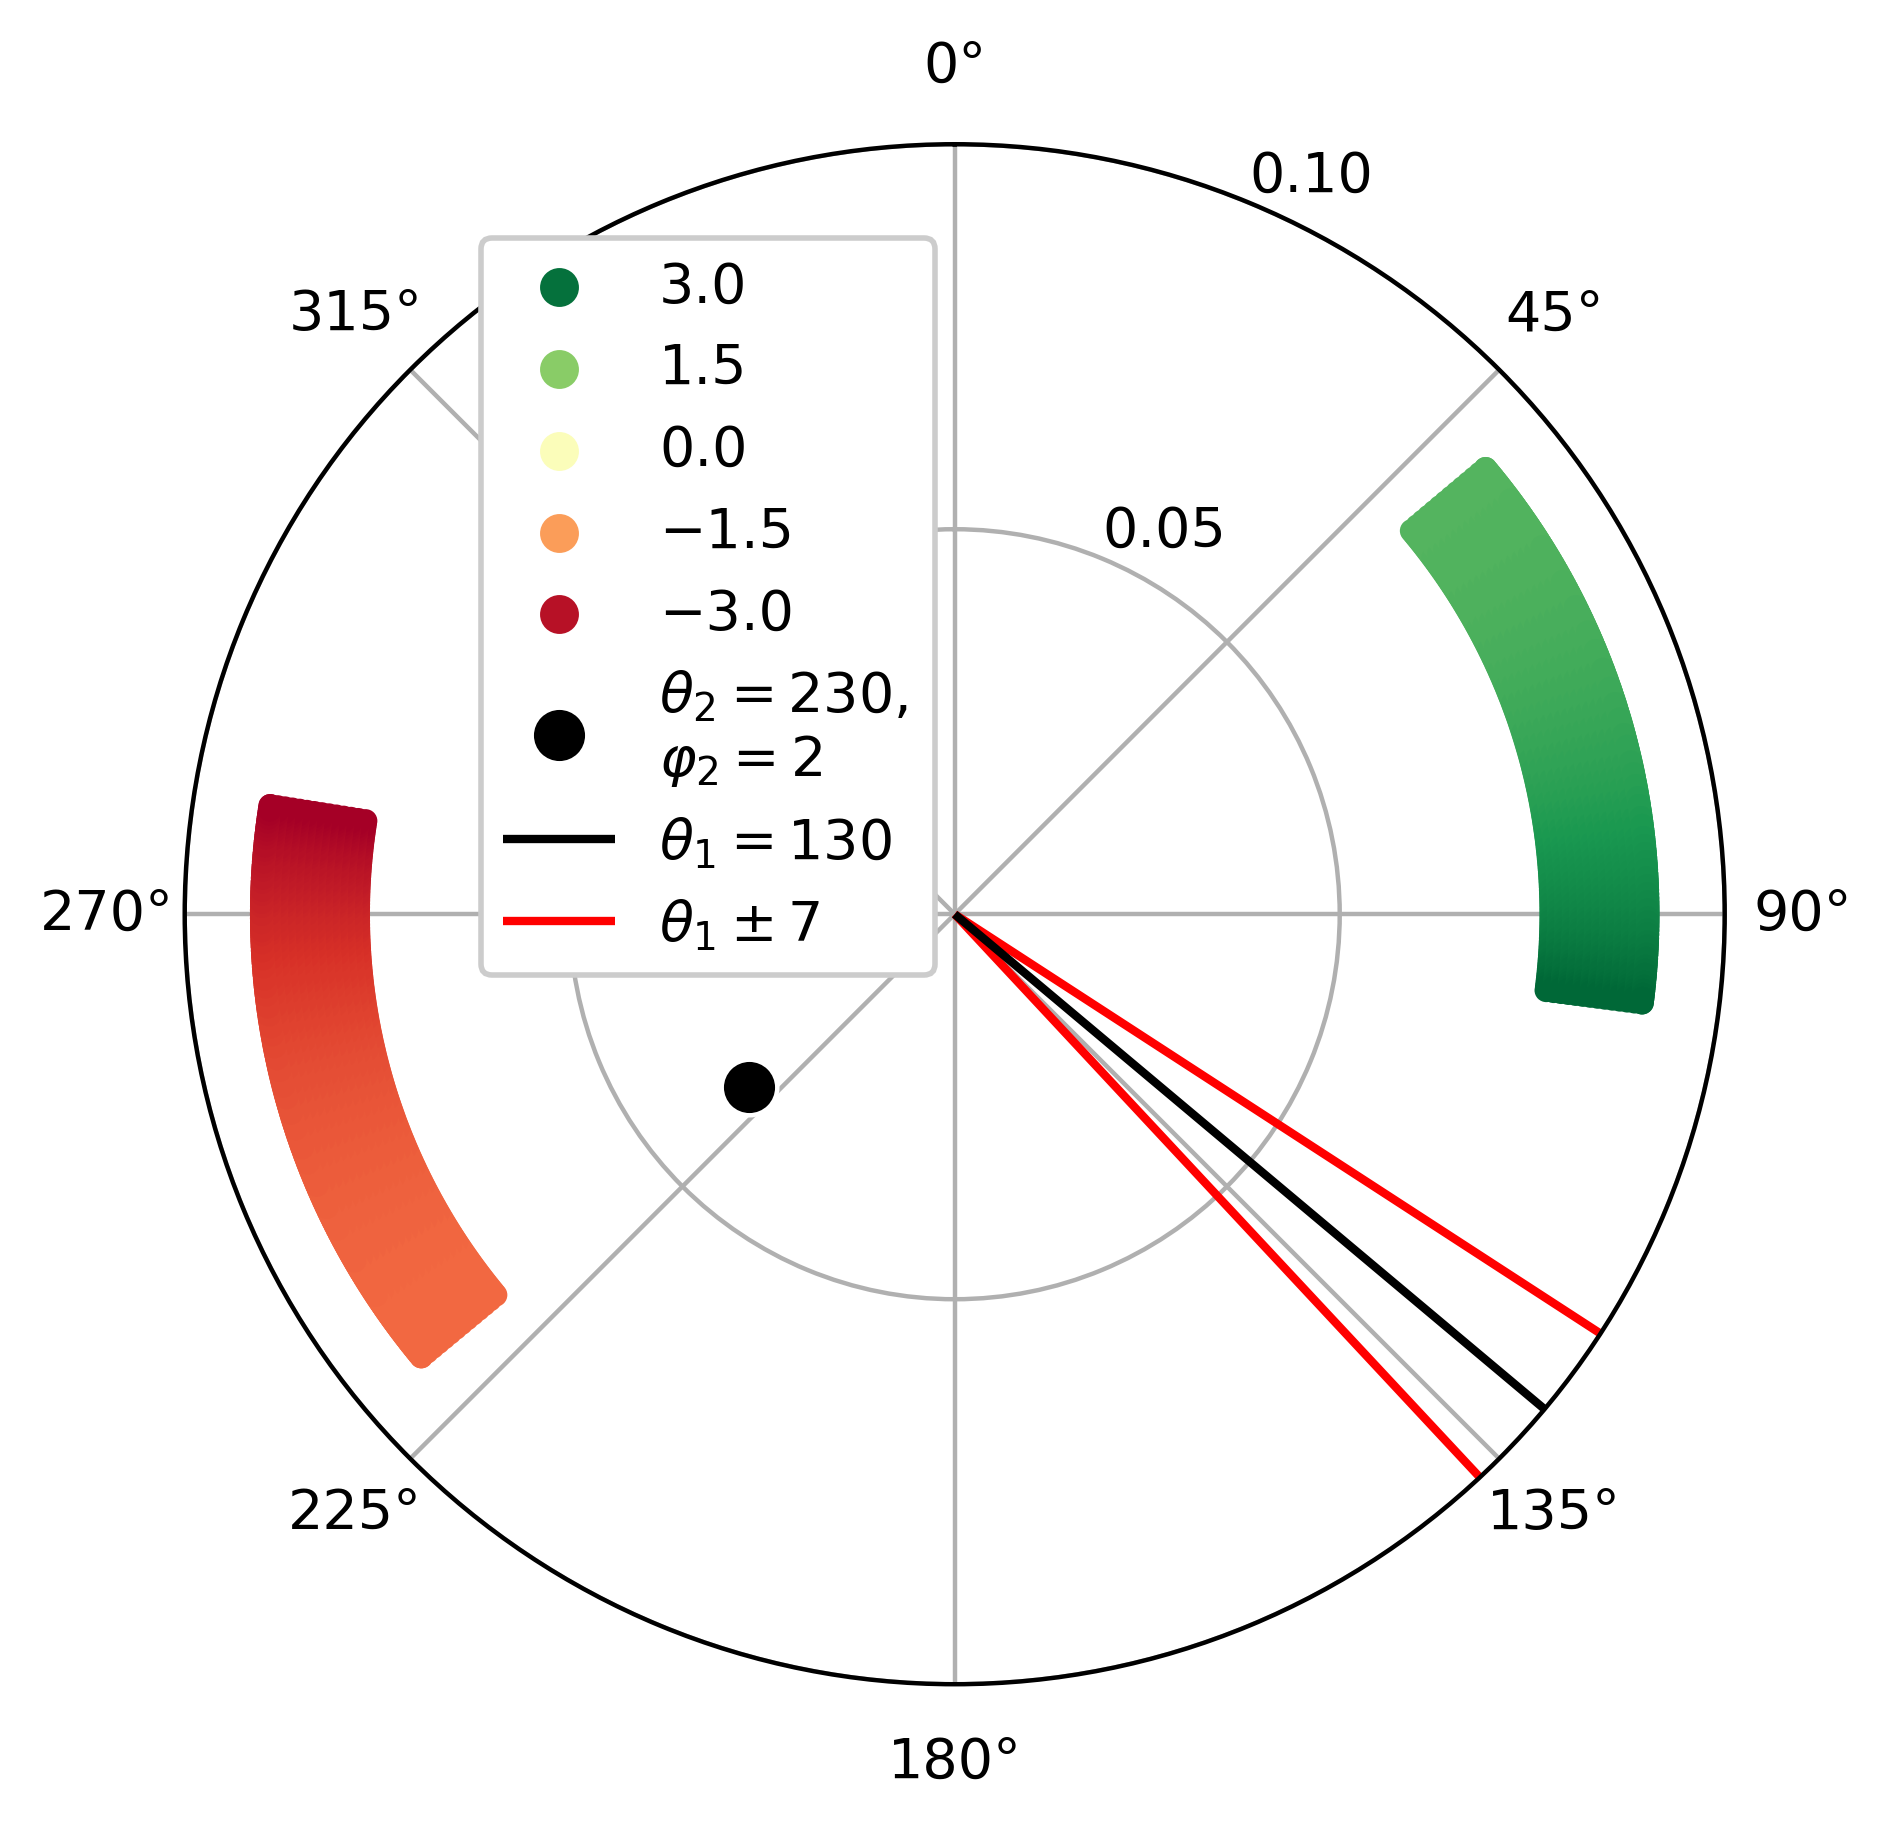

In [8]:
# td.tilt_check(az1=130, az2=110, sl2=4, legend_position=(.34, .5))
td.tilt_check(az1=130, az2=230, sl2=2, legend_position=(0.34, 0.7))

## Map Data

In [5]:
map_path = "../GEOL192-GIS/data/"

centers = pd.read_csv(f'{map_path}centers.csv').set_index('cID')
samples = pd.read_csv(f'{map_path}samples.csv').set_index('sID')

cIDs = centers.index.tolist()
sIDs = samples.index.tolist()

feature_sIDs = {
    'flow': samples.index[samples['FEATURE'] == 'flow'].tolist(),
    'channel': samples.index[samples['FEATURE'] == 'channel'].tolist(),
}

Calculate tilt (etc.) for each sample, repeat for each center. Full dataset from which to pull subsets later.

In [7]:
centers_calc = {
    cID: td.make_center(cID, centers, samples) for cID in cIDs
}

Define populations for each evaluation.

In [8]:
POP_A_sIDs = [
    198, 438, 439, 440, 441, 442, 443, 444, 445, 490, 491, 492, 493
]

POP_B_sIDs = [
    193, 194, 195, 196, 197, 477, 478, 479, 480, 481, 544, 545, 548, 549
]

POP_C_sIDs = [
    529, 530, 531, 532, 533, 537, 538, 539, 540, 541, 542, 543
]

pop_all = td.Population(name='all', sIDs=sIDs)
pop_flow = td.Population(name='flow', sIDs=feature_sIDs['flow'])
pop_channel = td.Population(name='channel', sIDs=feature_sIDs['channel'])

pop_a = td.Population(name='A', sIDs=POP_A_sIDs)
pop_b = td.Population(name='B', sIDs=POP_B_sIDs)
pop_c = td.Population(name='C', sIDs=POP_C_sIDs)

criteria = [
    td.Criterion(td.summit_score, pop_all),
    td.Criterion(td.summit_score, pop_flow),
    td.Criterion(td.summit_score, pop_channel),
    td.Criterion(td.inflation_score, pop_a),
    td.Criterion(td.inflation_score, pop_b),
    td.Criterion(td.inflation_score, pop_c),
]

Perform evaluation. This takes a few minutes on my machine.

In [14]:
scores = {}
score_names = []

# note: will get score name out of order if any criteria throw errors, so those need to be handled in each evaluation function
for cID in cIDs[:50]:

    center = centers_calc[cID]
    centers_eval = []

    for crit in criteria:
        center_crit_scores = td.evaluate_center(center, crit)

        for key, val in center_crit_scores.items():
            centers_eval.append(val)

            full_score_name = f'{crit.pop.name}_{key}'

            if full_score_name not in score_names:
                score_names.append(full_score_name)
                
    scores[cID] = centers_eval

Write evaluation to disk.

In [15]:
centers_eval = pd.DataFrame(scores).transpose().set_axis(score_names, axis=1)


centers_eval_no_infs = centers_eval.replace([np.inf, -np.inf], np.nan)

centers_eval_no_infs.to_csv(
    f'{map_path}centers_eval_first50_from_import.csv',
    index_label='cID'
)

## Model data

Define parameter combinations.

In [10]:
grav_topo_test_params = {
    "depth": [15_000],
    "radius": [20_000],
    "aspect": [.4],
    "pmult": [.6],
    "grav": [True, False],
    "topo": [True, False],
}

mogi_shallow_oblate_test_params = {
    "depth": [15_000, 20000],
    "radius": [20_000],
    "aspect": [.4],
    "pmult": [.6],
    "grav": [False],
    "topo": [True],
}

mogi_test_params = {
    "depth": [25_000],
    "radius": [5_000],
    "aspect": [1],
    "pmult": [1],
    "grav": [False],
    "topo": [False],
}

full_params = {
    "depth": [25_000], # 25
    "radius": [5_000], # 5
    "aspect": [1],
    "pmult": [1],
    "grav": [False],
    "topo": [False],
}

mogi_test_params_singleton = td.unpack_param_combinations(mogi_test_params)[0]

mogi_test_params_singleton

{'depth': 25000,
 'radius': 5000,
 'aspect': 1,
 'pmult': 1,
 'grav': False,
 'topo': False}

In [11]:
mogi_test_model = td.make_numerical_model(mogi_test_params_singleton)
type(mogi_test_model)

topodisc.NumericalModel

In [12]:
grav_topo_test_sweep = td.ParamSweep(
    td.unpack_param_combinations(grav_topo_test_params)
)

(0.0, 50.0)

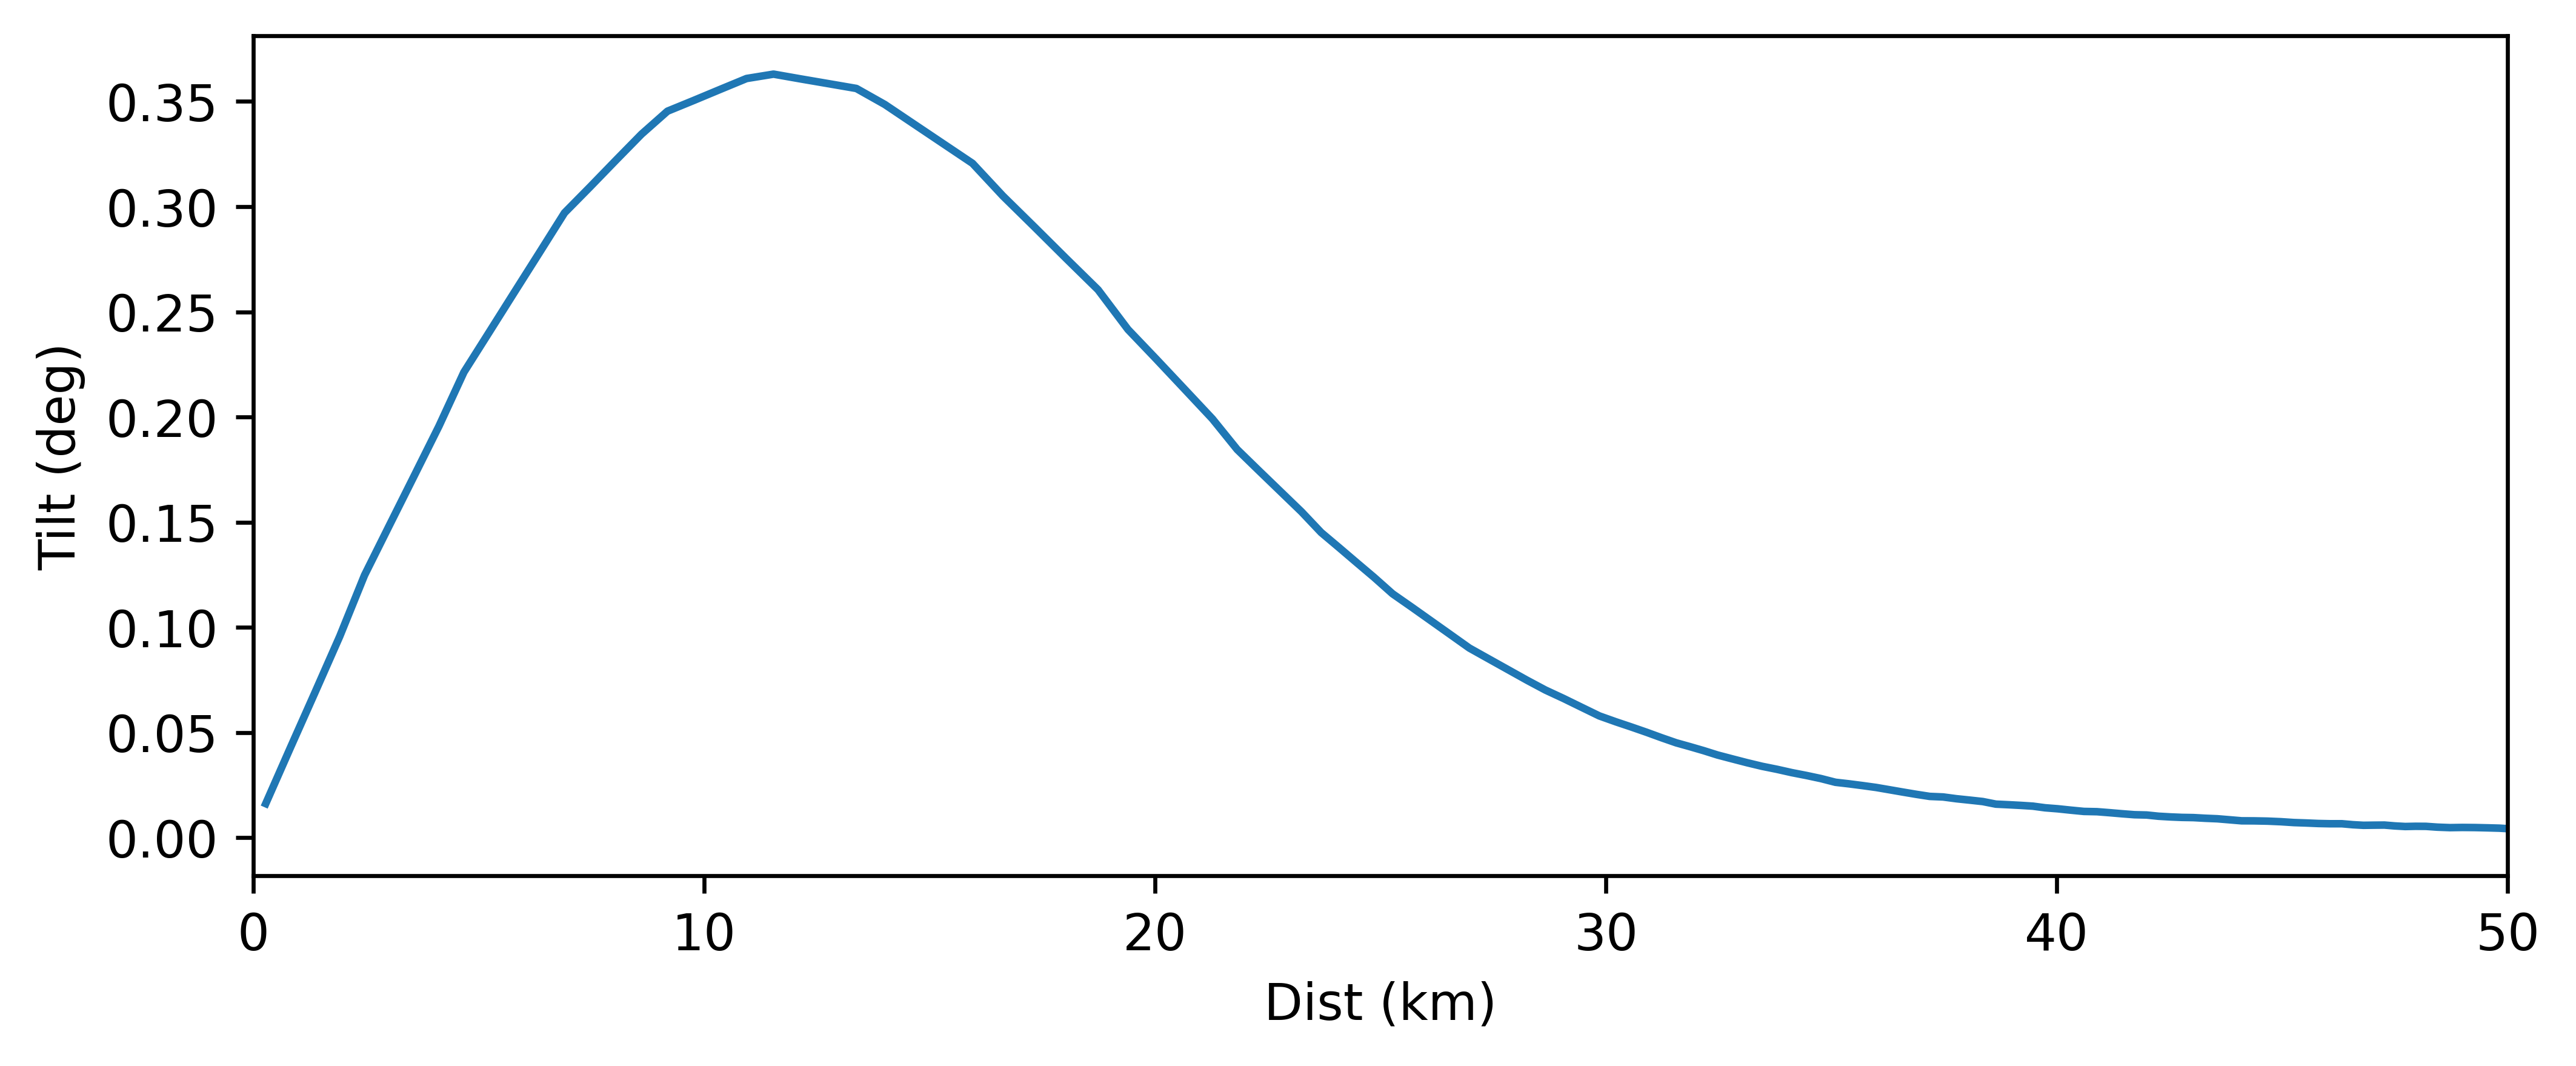

In [13]:
plt.figure(figsize=(8,3), dpi=600)

grav_topo_test_sweep.models[0].plot_numerical_tilt()

plt.ylabel('Tilt (deg)')
plt.xlabel('Dist (km)')
plt.xlim(0, 50)
#plt.ylim(0.3, 0.4)